In [64]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [65]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [66]:
from torchvision import datasets
from torchvision.transforms import ToTensor
train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
test_data = datasets.FashionMNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)

In [67]:
print(train_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()


In [68]:
print(test_data)

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


In [69]:
print(train_data.data.size())

torch.Size([60000, 28, 28])


In [70]:
print(test_data.data.size())

torch.Size([10000, 28, 28])


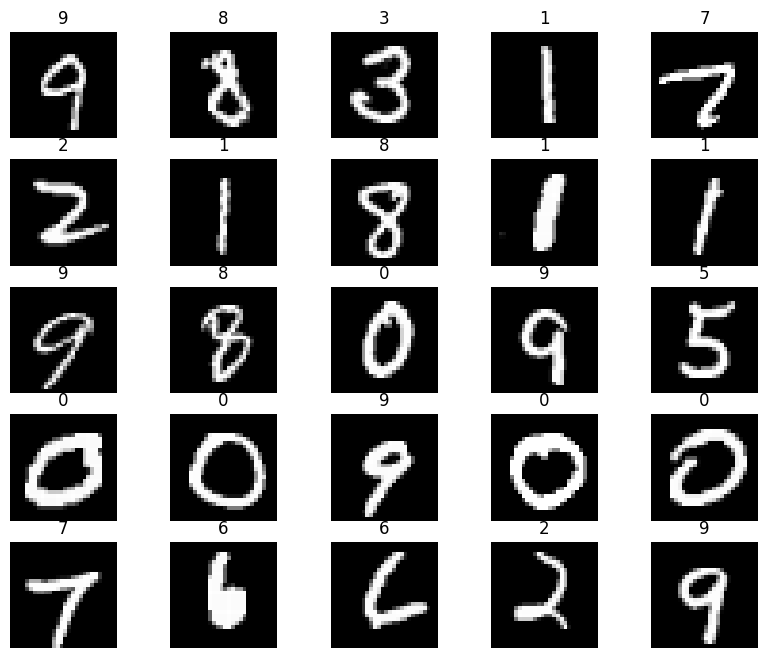

In [81]:
import matplotlib.pyplot as plt
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [82]:
from torch.utils.data import DataLoader
loaders = {
    'train' : torch.utils.data.DataLoader(train_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
    
    'test'  : torch.utils.data.DataLoader(test_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
}
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7f4c6ce14950>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7f4c6d164dd0>}

In [83]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1,64,3),
            nn.ReLU(),
            nn.MaxPool2d((2,2),stride=2),
            nn.Conv2d(64,128,3),
            nn.ReLU(),
            nn.MaxPool2d((2,2),stride=2),
            nn.Conv2d(128,64,3),
            nn.ReLU(),
            nn.MaxPool2d((2,2),stride=2)
        )
        self.classification_head=nn.Sequential(nn.Linear(64,20,bias=True),
                                               nn.ReLU(),
                                               nn.Linear(20,10,bias=True))
    def forward(self,x):
        features = self.net(x)
        return self.classification_head(features.view(100,-1))
            
        

In [84]:
cnn = CNN().to(device)

In [85]:
print(cnn)

CNN(
  (net): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classification_head): Sequential(
    (0): Linear(in_features=64, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=10, bias=True)
  )
)


In [86]:
loss_func = nn.CrossEntropyLoss().to(device)

In [87]:
from torch import optim
optimizer = optim.Adam(cnn.parameters(), lr = 0.01)   
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)

In [88]:
sum(p.numel() for p in cnn.parameters())

149798

In [89]:
losses = []
for batch,labels in loaders['train']:
    batch = batch.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()
    loss = loss_func(cnn(batch),labels)
    losses.append(loss.item())
    print(loss.item())
    loss.backward()
    optimizer.step()
    

2.3152756690979004
2.9277853965759277
2.31784725189209
2.3063628673553467
2.2844698429107666
2.2999205589294434
2.3001527786254883
2.278465747833252
2.308509588241577
2.293470621109009
2.316432476043701
2.3025753498077393
2.269676685333252
2.2770748138427734
2.3014419078826904
2.284788131713867
2.2516257762908936
2.2349534034729004
2.2282967567443848
2.2255795001983643
2.2146177291870117
2.1341681480407715
2.119450330734253
2.105253219604492
2.0943105220794678
2.084939479827881
1.9852300882339478
1.9400264024734497
2.0133304595947266
1.8997201919555664
1.8663694858551025
1.8767346143722534
1.7140558958053589
1.7077875137329102
1.701973557472229
1.5462980270385742
1.504704475402832
1.3834526538848877
1.3524627685546875
1.6181660890579224
1.4437382221221924
1.431563138961792
1.2353721857070923
1.2738745212554932
1.2050940990447998
1.3024394512176514
1.2632542848587036
1.000206708908081
1.2074482440948486
1.0610806941986084
1.0223267078399658
1.0410574674606323
1.1744470596313477
0.974038

In [90]:
print("Models state dict :")
for param_tensor in cnn.state_dict().keys():
    print(param_tensor,'\t',cnn.state_dict()[param_tensor])

Models state dict :
net.0.weight 	 tensor([[[[-0.5351, -0.8071, -0.5157],
          [-0.5779,  0.1152, -0.3488],
          [-0.0786,  0.3188,  0.5464]]],


        [[[-0.1004,  0.1374,  0.4594],
          [-0.6126,  0.2021,  0.1305],
          [-0.3664, -0.5599, -0.5298]]],


        [[[ 0.1971,  0.1605, -0.6006],
          [ 0.1835, -0.3675, -0.2878],
          [ 0.1857,  0.4969,  0.3420]]],


        [[[ 0.0514,  0.0088, -0.6559],
          [-0.9731, -0.8514, -1.0668],
          [-0.0432,  0.4494, -0.2250]]],


        [[[-0.4034, -0.1374, -0.4730],
          [-0.1444,  0.0425,  0.1912],
          [ 0.2566, -0.2670, -0.1886]]],


        [[[ 0.2225,  0.2480, -0.2001],
          [ 0.0104,  0.1020, -0.1707],
          [ 0.1459,  0.0052,  0.3417]]],


        [[[-0.3765, -0.4973,  0.0512],
          [-0.4164,  0.0718,  0.4171],
          [ 0.4356,  0.2623, -0.1087]]],


        [[[ 0.2530,  0.1649,  0.5778],
          [-0.3410, -0.0471, -0.2847],
          [-0.6803, -0.4925, -0.5665]]],

In [91]:
print("Optimizer state dict :")
for param_tensor in optimizer.state_dict().keys():
    print(param_tensor,'\t',optimizer.state_dict()[param_tensor])

Optimizer state dict :
state 	 {0: {'step': tensor(600.), 'exp_avg': tensor([[[[ 1.5729e-04,  2.5845e-04,  2.3660e-04],
          [ 1.2898e-03,  1.4783e-03,  1.7705e-03],
          [ 2.4923e-03,  3.4139e-03,  3.4745e-03]]],


        [[[-5.7766e-04, -1.4887e-03, -1.7564e-03],
          [-1.7923e-04, -7.2466e-04, -1.0856e-03],
          [-1.4463e-04, -1.6551e-04, -5.1327e-04]]],


        [[[-1.2321e-03,  2.0826e-03,  2.3265e-03],
          [-1.1000e-03,  8.8468e-04, -1.3087e-03],
          [-2.7962e-03, -5.4566e-03, -7.3946e-03]]],


        [[[ 6.0523e-04, -5.4932e-04, -1.1342e-04],
          [ 2.6438e-04, -2.3864e-05,  2.5983e-04],
          [ 1.4268e-03,  1.4347e-03,  2.8445e-03]]],


        [[[ 1.3069e-04,  1.4514e-04,  2.2065e-04],
          [-2.4416e-04,  1.3489e-04,  5.3432e-04],
          [-2.6962e-04,  3.8873e-04,  7.3387e-04]]],


        [[[ 5.4436e-03,  3.4870e-03,  1.0783e-03],
          [ 4.8617e-03,  3.0781e-03, -2.0036e-04],
          [ 1.6138e-03,  3.9393e-04, -4.4316

In [92]:
torch.save(cnn,'./ModelFiles/model.pt')

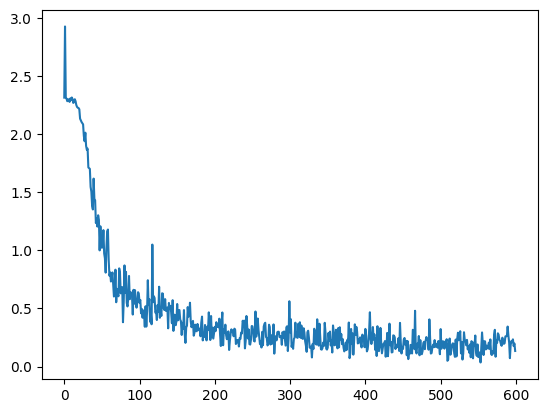

In [93]:
plt.plot(losses)

In [94]:
model = CNN()

In [95]:
model = torch.load('./ModelFiles/model.pt')

In [96]:
model.to(device)

CNN(
  (net): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classification_head): Sequential(
    (0): Linear(in_features=64, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=10, bias=True)
  )
)

In [97]:
print("Models state dict :")
for param_tensor in model.state_dict().keys():
    print(param_tensor,'\t',model.state_dict()[param_tensor])

Models state dict :
net.0.weight 	 tensor([[[[-0.5351, -0.8071, -0.5157],
          [-0.5779,  0.1152, -0.3488],
          [-0.0786,  0.3188,  0.5464]]],


        [[[-0.1004,  0.1374,  0.4594],
          [-0.6126,  0.2021,  0.1305],
          [-0.3664, -0.5599, -0.5298]]],


        [[[ 0.1971,  0.1605, -0.6006],
          [ 0.1835, -0.3675, -0.2878],
          [ 0.1857,  0.4969,  0.3420]]],


        [[[ 0.0514,  0.0088, -0.6559],
          [-0.9731, -0.8514, -1.0668],
          [-0.0432,  0.4494, -0.2250]]],


        [[[-0.4034, -0.1374, -0.4730],
          [-0.1444,  0.0425,  0.1912],
          [ 0.2566, -0.2670, -0.1886]]],


        [[[ 0.2225,  0.2480, -0.2001],
          [ 0.0104,  0.1020, -0.1707],
          [ 0.1459,  0.0052,  0.3417]]],


        [[[-0.3765, -0.4973,  0.0512],
          [-0.4164,  0.0718,  0.4171],
          [ 0.4356,  0.2623, -0.1087]]],


        [[[ 0.2530,  0.1649,  0.5778],
          [-0.3410, -0.0471, -0.2847],
          [-0.6803, -0.4925, -0.5665]]],

In [98]:
model.eval()

CNN(
  (net): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classification_head): Sequential(
    (0): Linear(in_features=64, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=10, bias=True)
  )
)

In [99]:
if torch.cuda.is_available():
    print('yay')

yay


In [101]:
total = 0
correct = 0
for batch,labels in loaders['test']:
    batch = batch.to(device)
    labels = labels.to(device)
    # model.to(device)
    preds = model(batch)
    for i in range(len(preds)):
        total+=1
        pred = preds[i].argmax().item()
        # print(pred.item(),end=',  ')
        actual = labels[i].item()
        if(pred == actual):
            correct +=1

print("accuracy : ",correct/total)
        

accuracy :  0.0619
